In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from collections import deque
from itertools import combinations
import heapq
from collections import defaultdict
# Load optimal schedule and employee data

# 174 Final Report

### Preliminary Modeling -- Monte Carlo Poisson Simulations
Using piece-wise homogeneous modeling given data collected 3-week span and averaged for day of week

In [2]:
# Importing dataset for binge customers per hour, collected over 3 weeks
binge = pd.read_excel("binge_data.xlsx")

In [3]:
binge

,Week,Day,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00
0,1,Mon,18,20,28,35,24,23,19,30,40,37,32
1,1,Tue,13,17,24,28,24,26,18,32,29,43,44
2,1,Wed,14,22,32,33,27,23,15,29,23,34,41
3,1,Thu,17,23,33,30,19,22,17,20,33,43,39
4,1,Fri,14,15,34,31,26,14,27,24,36,39,56
5,1,Sat,23,22,46,39,30,30,21,33,41,54,46
6,1,Sun,20,20,30,47,33,36,27,47,59,39,43
7,2,Mon,16,13,30,26,18,25,18,36,27,49,36
8,2,Tue,17,12,42,41,24,28,21,34,37,35,43
9,2,Wed,14,14,35,23,19,19,20,29,27,25,43


In [4]:
#computing average over three weeks to compute lambdas for the dataset
binge_average = binge.groupby(['Day']).mean().drop(columns=['Week'])
week_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
binge_average = binge_average.reindex(week_order)
binge_average

,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00
Day,,,,,,,,,,,
Mon,16.000000,18.000000,27.000000,31.666667,22.666667,23.333333,22.000000,31.666667,35.666667,39.666667,37.000000
Tue,13.000000,16.000000,32.333333,36.666667,25.333333,25.000000,20.666667,34.333333,36.000000,40.000000,40.666667
Wed,11.666667,18.666667,30.000000,31.000000,24.000000,21.333333,22.000000,28.000000,27.666667,29.333333,40.000000
Thu,14.666667,16.333333,29.333333,32.333333,19.333333,21.333333,25.333333,32.666667,37.666667,40.666667,39.000000
Fri,18.666667,16.333333,29.333333,31.666667,23.666667,17.333333,24.000000,35.333333,32.000000,37.666667,49.000000
Sat,22.000000,23.000000,37.000000,34.333333,31.000000,27.666667,31.000000,39.666667,39.333333,49.333333,50.333333
Sun,18.333333,23.666667,40.000000,45.000000,32.666667,29.666667,28.666667,48.333333,52.666667,45.666667,53.666667


In [5]:
### ADJUSTING BASED ON EMPLOYEE DRINK MAKING TIMES

In [6]:
# Core NHPP-by-hour arrival generation (exact for stepwise λ)

def simulate_arrivals_one_hour(lam_h, hour_len=3600.0, rng=None):
    """
    Generate arrival times for one hour with homogeneous Poisson rate lam_h (arrivals/hour).
    Returns sorted arrival times (seconds from hour start).
    """
    rng = np.random.default_rng(rng)
    n = rng.poisson(lam=lam_h)  # hour length = 1, so mean = lam_h * 1
    if n == 0:
        return np.empty(0, dtype=float)
    u = rng.random(n)
    return np.sort(u * hour_len)

# Multi-server queue simulator with heterogeneous employees
def simulate_hour_queue(arrivals_sec, employees_mus_per_sec, rng=None):
    """
    Simulate one hour (plus any spillover until all in service finish).
    arrivals_sec: np.array of arrival times within the hour [0, 3600)
    employees_mus_per_sec: list of service rates per employee in 1/seconds (μ_i).
    Returns: dict with mean_wait (s), util_by_emp, num_in_system_at_hour_end, total_service_time_by_emp.
    """
    rng = np.random.default_rng(rng)
    HOUR_END = 3600.0

    if len(employees_mus_per_sec) == 0:
        # No staff: everyone waits until infinite; we’ll handle by returning inf
        return {
            "mean_wait": float('inf'),
            "num_in_system_at_hour_end": len(arrivals_sec),
            "util_by_emp": np.zeros(0),
            "total_service_time_by_emp": np.zeros(0),
        }

    # Min-heap of (next_free_time, emp_idx)
    # All servers free at t=0 initially
    free_heap = [(0.0, i) for i in range(len(employees_mus_per_sec))]
    heapq.heapify(free_heap)

    waits = []
    # Track busy time to compute utilization
    total_service_time = np.zeros(len(employees_mus_per_sec))

    for t in arrivals_sec:
        next_free_time, emp = heapq.heappop(free_heap)
        start = max(t, next_free_time)
        mu_i = employees_mus_per_sec[emp]
        service = rng.exponential(scale=1.0/mu_i)  # Exp with mean 1/μ_i
        depart = start + service
        waits.append(start - t)
        total_service_time[emp] += service
        heapq.heappush(free_heap, (depart, emp))

    # Customers still in system at HOUR_END
    num_in_system_at_hour_end = sum(1 for ft, _ in free_heap if ft > HOUR_END)

    # Utilization per employee over the hour (truncate to 3600 if desired)
    util = np.minimum(total_service_time / HOUR_END, 1.0)

    return {
        "mean_wait": float(np.mean(waits)) if waits else 0.0,
        "num_in_system_at_hour_end": int(num_in_system_at_hour_end),
        "util_by_emp": util,
        "total_service_time_by_emp": total_service_time,
    }

In [7]:
# Evaluate staffing options via simulation
def evaluate_staffing_for_hour(
    lam_h,
    employees_speeds_drinks_per_min,  # dict: name -> drinks/min
    min_staff=3,
    max_staff=4,
    replications=200,
    current_daily_hours=None,
    current_weekly_hours=None,
    max_daily_hours=None,
    max_weekly_hours=None,
    rng=None
):
    """
    For a given hour arrival rate lam_h, simulate all combos of employees with size in [min_staff, max_staff].
    Pick the combo minimizing mean wait (seconds). Returns best_choice dict.
    """
    rng = np.random.default_rng(rng)

    # Precompute arrivals for each replication to keep arrivals consistent across combos (fair comparison)
    arrivals_per_rep = [simulate_arrivals_one_hour(lam_h, rng=rng) for _ in range(replications)]

    all_names = list(employees_speeds_drinks_per_min.keys())
    all_speeds = np.array([employees_speeds_drinks_per_min[n] for n in all_names], dtype=float) # drinks/min
    all_mus_per_sec = all_speeds / 60.0 # services per second

    eligible_employee_info = []
    for i, name in enumerate(all_names):
        can_work_daily = (current_daily_hours is None) or (current_daily_hours[name] < max_daily_hours)
        can_work_weekly = (current_weekly_hours is None) or (current_weekly_hours[name] < max_weekly_hours)
        if can_work_daily and can_work_weekly:
            eligible_employee_info.append((name, all_mus_per_sec[i]))

    eligible_names = [info[0] for info in eligible_employee_info]
    eligible_mus_per_sec = [info[1] for info in eligible_employee_info]

    # Adjust min_staff and max_staff based on eligible employees
    num_eligible = len(eligible_names)
    current_min_staff = max(0, min(min_staff, num_eligible))
    current_max_staff = min(max_staff, num_eligible)

    best = {
        "employees": [], # Changed to empty list for better default
        "mean_wait_sec": float('inf'),
        "utilization_by_emp": None,
        "num_in_system_at_hour_end": None
    }

    # Only proceed if there are enough eligible employees to meet at least min_staff
    if current_min_staff > 0 and num_eligible > 0:
        for k in range(current_min_staff, current_max_staff + 1):
            for idxs in combinations(range(num_eligible), k):
                # Build μ list for chosen employees
                selected_names = [eligible_names[i] for i in idxs]
                selected_mus_sec = [eligible_mus_per_sec[i] for i in idxs]

                # Run simulation across replications
                waits = []
                end_in_system = []
                utils_accum = np.zeros(k)

                for r in range(replications):
                    res = simulate_hour_queue(arrivals_per_rep[r], selected_mus_sec, rng=rng)
                    waits.append(res["mean_wait"])
                    end_in_system.append(res["num_in_system_at_hour_end"])
                    # Align utilization vector order with selected employees
                    utils_accum += res["util_by_emp"]

                mean_wait = float(np.mean(waits)) if waits else float('inf')
                mean_end_in_system = float(np.mean(end_in_system))
                mean_utils = utils_accum / replications

                if mean_wait < best["mean_wait_sec"]:
                    best = {
                        "employees": selected_names,
                        "mean_wait_sec": mean_wait,
                        "utilization_by_emp": dict(zip(selected_names, mean_utils)),
                        "num_in_system_at_hour_end": mean_end_in_system
                    }
    # If no valid combination could be found (e.g. not enough eligible staff), best.employees remains empty
    if not best["employees"] and current_min_staff > 0:
        # This can happen if there are eligible employees but not enough to meet min_staff
        pass


    return best

# Planning across a full day and full week
def plan_week_schedule(
    lambda_df, # pandas DataFrame: index=days, columns=hours, values=λ
    employees_speeds_drinks_per_min, # dict name -> drinks/min
    min_staff=2,
    max_staff=4,
    replications=200,
    max_daily_hours_per_employee=6,
    max_weekly_hours_per_employee=30,
    rng=88
):
    """
    For each day/hour (row/column in lambda_df),
    choose staffing combo (3–4 employees) minimizing mean wait.
    Returns nested results {day: [{hour,...}, ...]} and a flattened summary DataFrame.
    """
    rng = np.random.default_rng(rng)

    results = {}
    records = []

    # Initialize weekly hours worked for each employee
    weekly_hours_worked = {name: 0 for name in employees_speeds_drinks_per_min.keys()}

    for day in lambda_df.index:
        # Initialize daily hours worked for each employee at the start of each day
        daily_hours_worked = {name: 0 for name in employees_speeds_drinks_per_min.keys()}

        lam_vec = lambda_df.loc[day].values.astype(float)
        day_out = []
        for hour, lam_h in zip(lambda_df.columns, lam_vec):
            best = evaluate_staffing_for_hour(
                lam_h=lam_h,
                employees_speeds_drinks_per_min=employees_speeds_drinks_per_min,
                min_staff=min_staff,
                max_staff=max_staff,
                replications=replications,
                current_daily_hours=daily_hours_worked,
                current_weekly_hours=weekly_hours_worked,
                max_daily_hours=max_daily_hours_per_employee,
                max_weekly_hours=max_weekly_hours_per_employee,
                rng=rng
            )

            # Update daily and weekly hours for chosen employees
            for emp_name in best["employees"]:
                daily_hours_worked[emp_name] += 1
                weekly_hours_worked[emp_name] += 1

            chosen_employees_str = ", ".join(best["employees"]) if best["employees"] else "No Staff Found"

            row = {
                "Day": day,
                "Hour": hour,
                "Lambda_per_hour": lam_h,
                "Expected_customers": lam_h,
                "Chosen_employees": chosen_employees_str,
                "Mean_wait_min": best["mean_wait_sec"]/60,
                "Avg_in_system_at_hour_end": best["num_in_system_at_hour_end"]
            }
            records.append(row)
            day_out.append(row)
        results[day] = day_out

    schedule_df = pd.DataFrame(records)
    return results, schedule_df, weekly_hours_worked

if __name__ == "__main__":
    lambdas_by_day = binge_average

    employees = {
        "Ava": 1.2, # drinks/min  => μ = 1.2/60 per second
        "Ben": 1.0,
        "Cara": 1.4,
        "Dee": 0.9,
        "Eli": 1.1,
        "Sean":0.8,
        "Lily":1.2,
        "Vivian":1.3,
        "Maya":1.1,
        "Paul":1.0,
        "Alex": 1.3,
        "Jordan": 1.2,
        "Sam": 1.0,
        "Taylor": 1.1,
    }

    # Choose 2–4 employees each hour to minimize average wait
    schedule, schedule_df_output, final_weekly_hours = plan_week_schedule(
        lambdas_by_day,
        employees_speeds_drinks_per_min=employees,
        min_staff=2,
        max_staff=4,
        replications=250,
        max_daily_hours_per_employee=6,
        max_weekly_hours_per_employee=30,
        rng=88
    )

    rows = []
    for slot in schedule["Fri"]:
        rows.append({
            "hour": slot["Hour"],
            "lambda": slot["Lambda_per_hour"],
            "expected_customers": slot["Expected_customers"],
            "chosen_employees": slot["Chosen_employees"],
        })
    df = pd.DataFrame(rows)
    print(df)
    print("\nFinal weekly hours worked:")
    print(final_weekly_hours)


     hour     lambda  expected_customers            chosen_employees
0   10:00  18.666667           18.666667         Ava, Ben, Cara, Dee
1   11:00  16.333333           16.333333           Ava, Vivian, Alex
2   12:00  29.333333           29.333333        Ava, Eli, Lily, Alex
3   13:00  31.666667           31.666667       Ava, Ben, Vivian, Sam
4   14:00  23.666667           23.666667        Ava, Ben, Cara, Lily
5   15:00  17.333333           17.333333        Ava, Ben, Cara, Sean
6   16:00  24.000000           24.000000      Ben, Cara, Vivian, Sam
7   17:00  35.333333           35.333333     Ben, Cara, Vivian, Paul
8   18:00  32.000000           32.000000  Cara, Vivian, Paul, Taylor
9   19:00  37.666667           37.666667  Lily, Vivian, Maya, Jordan
10  20:00  49.000000           49.000000   Lily, Jordan, Sam, Taylor

Final weekly hours worked:
{'Ava': 30, 'Ben': 30, 'Cara': 30, 'Dee': 13, 'Eli': 24, 'Sean': 4, 'Lily': 30, 'Vivian': 30, 'Maya': 16, 'Paul': 10, 'Alex': 30, 'Jordan': 26, 

## Visualizations and Cost Analysis

This section provides detailed visualizations of the optimal schedule 


### Averaged Monte Carlo Simulations on Demand

C:\Users\katie\AppData\Local\Temp\ipykernel_25720\2460023760.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(hours, rotation=45, ha='right')


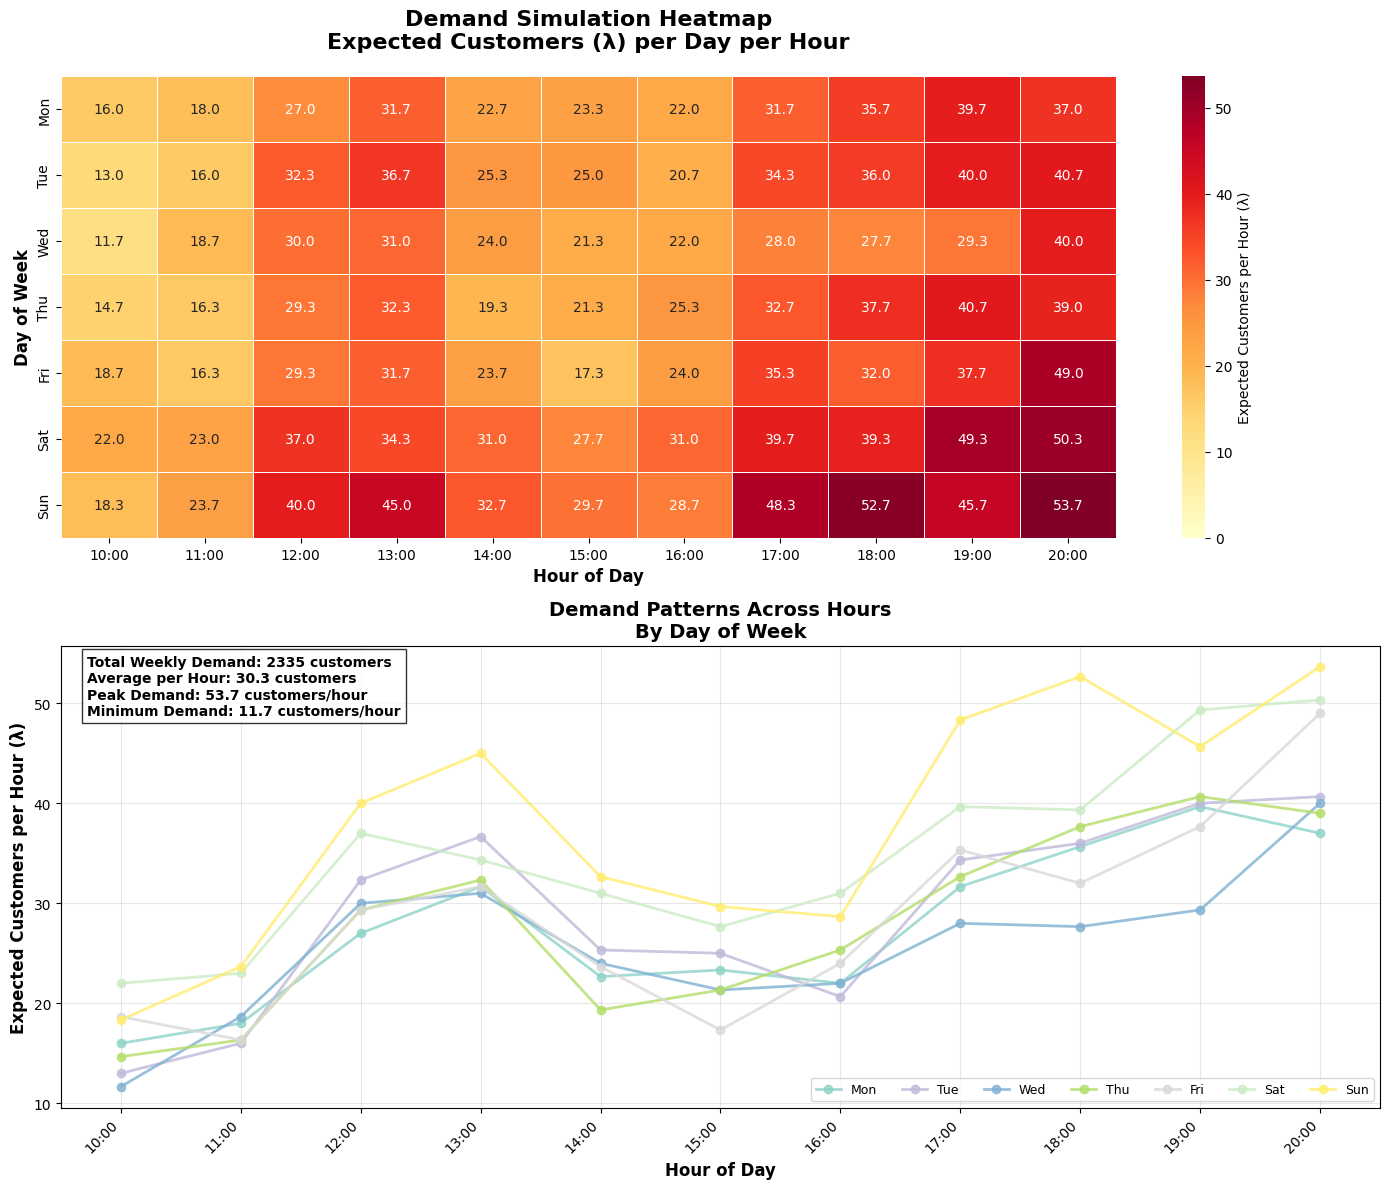

Demand simulation visualization saved as: demand_simulation_visualization.png

Demand Summary:
  Total Weekly Demand: 2335 customers
  Average Demand per Hour: 30.3 customers
  Peak Demand: 53.7 customers/hour
  Minimum Demand: 11.7 customers/hour


In [8]:
# Demand Simulation Visualization
# Show the demand (lambda) values used in Monte Carlo simulations per day per hour
if 'schedule_df_output' in globals():
    # Create pivot table from schedule_df_output
    demand_pivot = schedule_df_output.pivot_table(
        index='Day',
        columns='Hour',
        values='Lambda_per_hour',
        aggfunc='mean'
    )
    # Reindex to ensure proper day order
    week_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    demand_pivot = demand_pivot.reindex(week_order)
else:
    # Fallback to binge_average if schedule_df_output not available
    demand_pivot = binge_average

# Create visualization with two subplots: heatmap and line plot
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# 1. Heatmap of demand per day per hour
ax1 = axes[0]
sns.heatmap(
    demand_pivot,
    annot=True,
    fmt='.1f',
    cmap='YlOrRd',
    linewidths=0.5,
    cbar_kws={'label': 'Expected Customers per Hour (λ)'},
    ax=ax1,
    vmin=0,
    vmax=demand_pivot.values.max()
)
ax1.set_title('Demand Simulation Heatmap\nExpected Customers (λ) per Day per Hour', 
              fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax1.set_ylabel('Day of Week', fontsize=12, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# 2. Line plot showing demand patterns across hours for each day
ax2 = axes[1]
hours = demand_pivot.columns.tolist()
colors_day = plt.cm.Set3(np.linspace(0, 1, len(demand_pivot.index)))

for i, day in enumerate(demand_pivot.index):
    ax2.plot(hours, demand_pivot.loc[day].values, 
             marker='o', linewidth=2, markersize=6, 
             label=day, color=colors_day[i], alpha=0.8)

ax2.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax2.set_ylabel('Expected Customers per Hour (λ)', fontsize=12, fontweight='bold')
ax2.set_title('Demand Patterns Across Hours\nBy Day of Week', fontsize=14, fontweight='bold')
ax2.legend(loc='best', ncol=7, fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xticklabels(hours, rotation=45, ha='right')

# Add summary statistics
total_demand = demand_pivot.sum().sum()
avg_demand_per_hour = demand_pivot.mean().mean()
max_demand = demand_pivot.values.max()
min_demand = demand_pivot.values.min()

summary_text = f'Total Weekly Demand: {total_demand:.0f} customers\n'
summary_text += f'Average per Hour: {avg_demand_per_hour:.1f} customers\n'
summary_text += f'Peak Demand: {max_demand:.1f} customers/hour\n'
summary_text += f'Minimum Demand: {min_demand:.1f} customers/hour'

ax2.text(0.02, 0.98, summary_text,
         transform=ax2.transAxes, fontsize=10, fontweight='bold',
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('demand_simulation_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Demand simulation visualization saved as: demand_simulation_visualization.png")
print(f"\nDemand Summary:")
print(f"  Total Weekly Demand: {total_demand:.0f} customers")
print(f"  Average Demand per Hour: {avg_demand_per_hour:.1f} customers")
print(f"  Peak Demand: {max_demand:.1f} customers/hour")
print(f"  Minimum Demand: {min_demand:.1f} customers/hour")


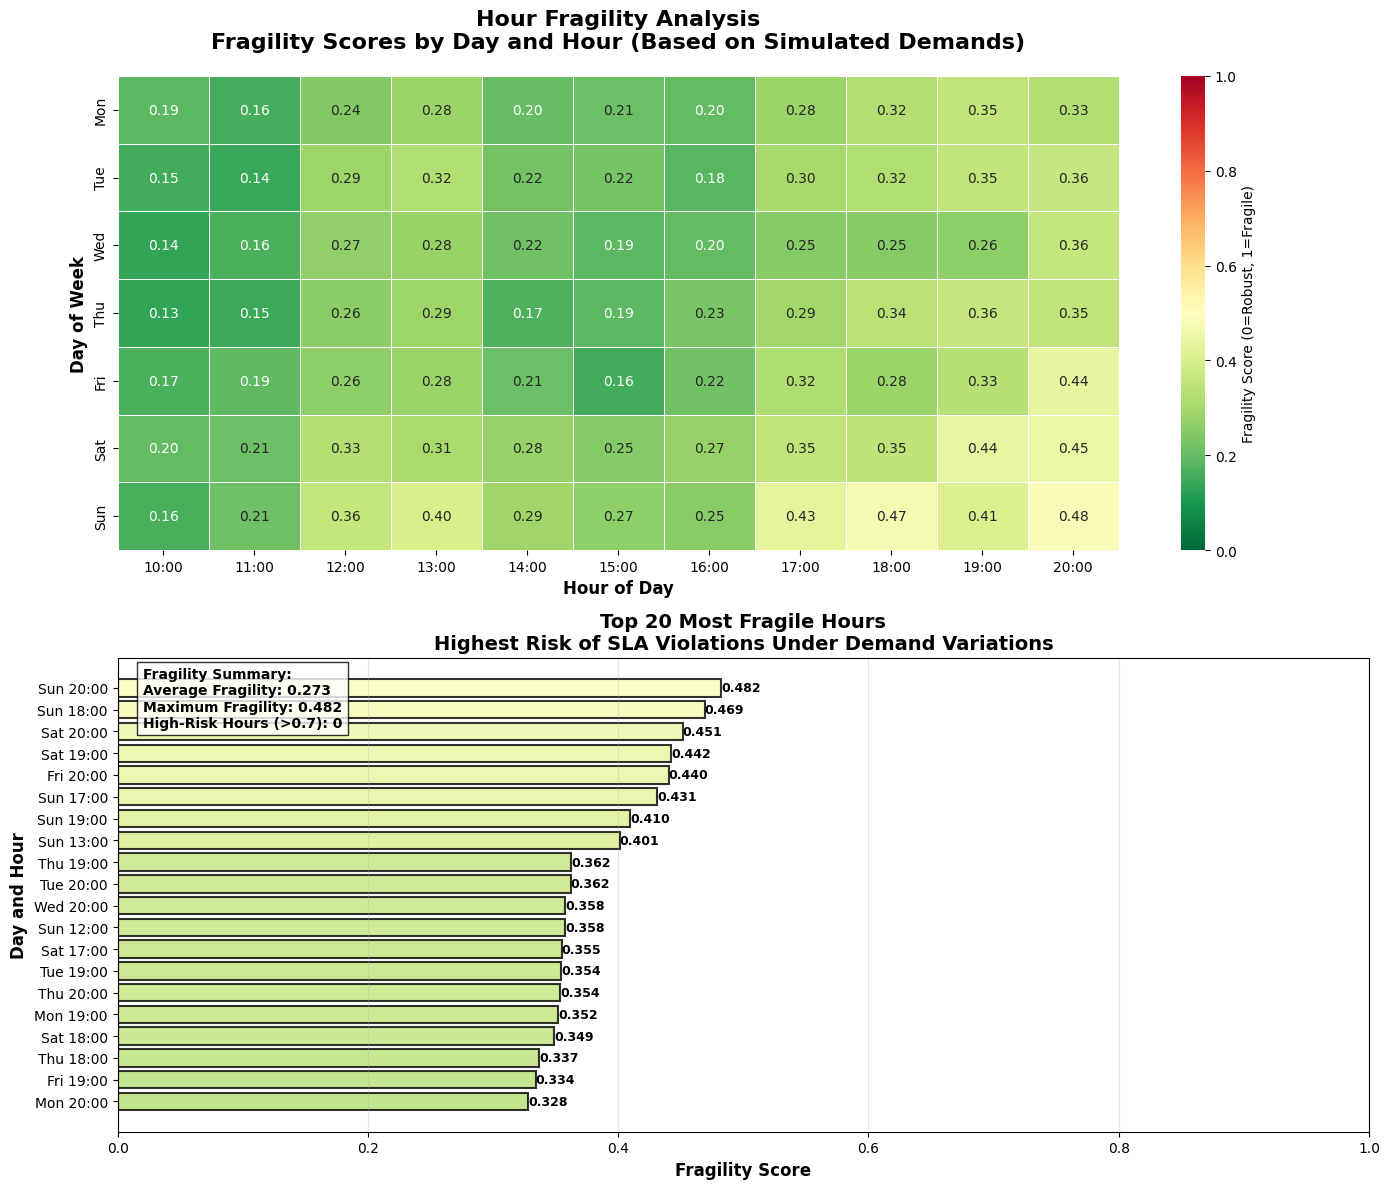

Fragility analysis visualization saved as: fragility_analysis.png

Fragility Summary:
  Average Fragility Score: 0.273
  Maximum Fragility Score: 0.482
  High-Risk Hours (Fragility > 0.7): 0
  Most Fragile Hour: Sun 20:00


In [9]:
# Fragility Analysis: Identifying Most Vulnerable Hours Based on Simulated Demands
# Fragility is calculated based on demand-to-staff ratio, wait times, and system load

if 'schedule_df_output' in globals():
    # Calculate fragility metrics for each hour
    fragility_data = []
    
    for idx, row in schedule_df_output.iterrows():
        day = row['Day']
        hour = row['Hour']
        lambda_h = row['Lambda_per_hour']
        num_employees = len(row['Chosen_employees'].split(', ')) if row['Chosen_employees'] != 'No Staff Found' else 0
        mean_wait = row['Mean_wait_min']
        avg_in_system = row['Avg_in_system_at_hour_end']
        
        # Calculate fragility score (higher = more fragile)
        # Factors: demand-to-staff ratio, wait time, system load
        if num_employees > 0:
            # Demand per employee (higher = more fragile)
            demand_per_employee = lambda_h / num_employees
            
            # Normalized wait time (higher wait = more fragile)
            wait_factor = min(mean_wait / 2.0, 1.0)  # Normalize to 0-1 (2 min = 1.0)
            
            # System load factor (more customers in system = more fragile)
            load_factor = min(avg_in_system / 5.0, 1.0)  # Normalize to 0-1 (5 customers = 1.0)
            
            # Combined fragility score (weighted average)
            fragility_score = 0.5 * (demand_per_employee / 15.0) + 0.3 * wait_factor + 0.2 * load_factor
            fragility_score = min(fragility_score, 1.0)  # Cap at 1.0
        else:
            fragility_score = 1.0  # Maximum fragility if no staff
        
        fragility_data.append({
            'Day': day,
            'Hour': hour,
            'Fragility_Score': fragility_score,
            'Demand': lambda_h,
            'Num_Employees': num_employees,
            'Demand_Per_Employee': lambda_h / num_employees if num_employees > 0 else lambda_h,
            'Mean_Wait_Min': mean_wait
        })
    
    df_fragility = pd.DataFrame(fragility_data)
    
    # Create pivot table for heatmap
    fragility_pivot = df_fragility.pivot_table(
        index='Day',
        columns='Hour',
        values='Fragility_Score',
        aggfunc='mean'
    )
    
    # Reindex to ensure proper day order
    week_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    fragility_pivot = fragility_pivot.reindex(week_order)
    
    # Create visualization with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # 1. Heatmap of fragility scores
    ax1 = axes[0]
    sns.heatmap(
        fragility_pivot,
        annot=True,
        fmt='.2f',
        cmap='RdYlGn_r',  # Red (fragile) to Green (robust), reversed
        linewidths=0.5,
        cbar_kws={'label': 'Fragility Score (0=Robust, 1=Fragile)'},
        ax=ax1,
        vmin=0,
        vmax=1.0
    )
    ax1.set_title('Hour Fragility Analysis\nFragility Scores by Day and Hour (Based on Simulated Demands)',
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Day of Week', fontsize=12, fontweight='bold')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
    
    # 2. Bar chart showing most fragile hours
    ax2 = axes[1]
    
    # Sort by fragility score and get top 20 most fragile hours
    top_fragile = df_fragility.nlargest(20, 'Fragility_Score')
    top_fragile['Day_Hour'] = top_fragile['Day'] + ' ' + top_fragile['Hour'].astype(str)
    
    # Sort for display
    top_fragile = top_fragile.sort_values('Fragility_Score', ascending=True)
    
    colors_fragile = plt.cm.RdYlGn_r(top_fragile['Fragility_Score'].values)
    bars = ax2.barh(range(len(top_fragile)), top_fragile['Fragility_Score'].values, 
                    color=colors_fragile, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax2.set_yticks(range(len(top_fragile)))
    ax2.set_yticklabels(top_fragile['Day_Hour'].values, fontsize=10)
    ax2.set_xlabel('Fragility Score', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Day and Hour', fontsize=12, fontweight='bold')
    ax2.set_title('Top 20 Most Fragile Hours\nHighest Risk of SLA Violations Under Demand Variations',
                  fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    ax2.set_xlim(0, 1.0)
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, top_fragile['Fragility_Score'].values)):
        width = bar.get_width()
        ax2.text(width, bar.get_y() + bar.get_height()/2.,
                f'{score:.3f}',
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Add summary statistics
    avg_fragility = df_fragility['Fragility_Score'].mean()
    max_fragility = df_fragility['Fragility_Score'].max()
    fragile_hours_count = len(df_fragility[df_fragility['Fragility_Score'] > 0.7])
    
    summary_text = f'Fragility Summary:\n'
    summary_text += f'Average Fragility: {avg_fragility:.3f}\n'
    summary_text += f'Maximum Fragility: {max_fragility:.3f}\n'
    summary_text += f'High-Risk Hours (>0.7): {fragile_hours_count}'
    
    ax2.text(0.02, 0.98, summary_text,
             transform=ax2.transAxes, fontsize=10, fontweight='bold',
             verticalalignment='top', horizontalalignment='left',
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('fragility_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Fragility analysis visualization saved as: fragility_analysis.png")
    print(f"\nFragility Summary:")
    print(f"  Average Fragility Score: {avg_fragility:.3f}")
    print(f"  Maximum Fragility Score: {max_fragility:.3f}")
    print(f"  High-Risk Hours (Fragility > 0.7): {fragile_hours_count}")
    print(f"  Most Fragile Hour: {df_fragility.loc[df_fragility['Fragility_Score'].idxmax(), 'Day']} {df_fragility.loc[df_fragility['Fragility_Score'].idxmax(), 'Hour']}")
else:
    print("schedule_df_output not found. Please run the scheduling optimization first.")

### Number of Employees Staffed

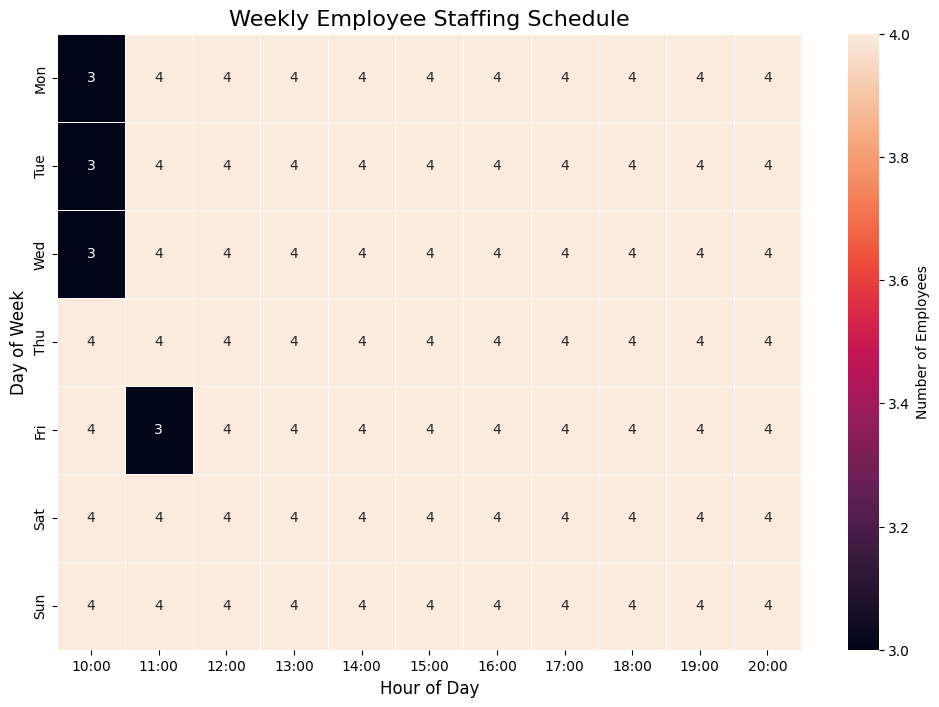

In [10]:
# Convert 'Chosen_employees' into a numerical count of employees
schedule_df_output['Num_Employees'] = schedule_df_output['Chosen_employees'].apply(
    lambda x: len(x.split(', ')) if x != 'No Staff Found' else 0
)

# Pivot the DataFrame
week_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
pivoted_schedule = schedule_df_output.pivot_table(
    index='Day',
    columns='Hour',
    values='Num_Employees'
).reindex(week_order)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivoted_schedule,
    annot=True,
    fmt="g",
    linewidths=.5,
    cbar_kws={'label': 'Number of Employees'}
)

plt.title('Weekly Employee Staffing Schedule', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.show()

C:\Users\katie\AppData\Local\Temp\ipykernel_25720\1008882803.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  schedule_by_day = schedule_by_day.fillna(0.0)  # Initialize with zeros


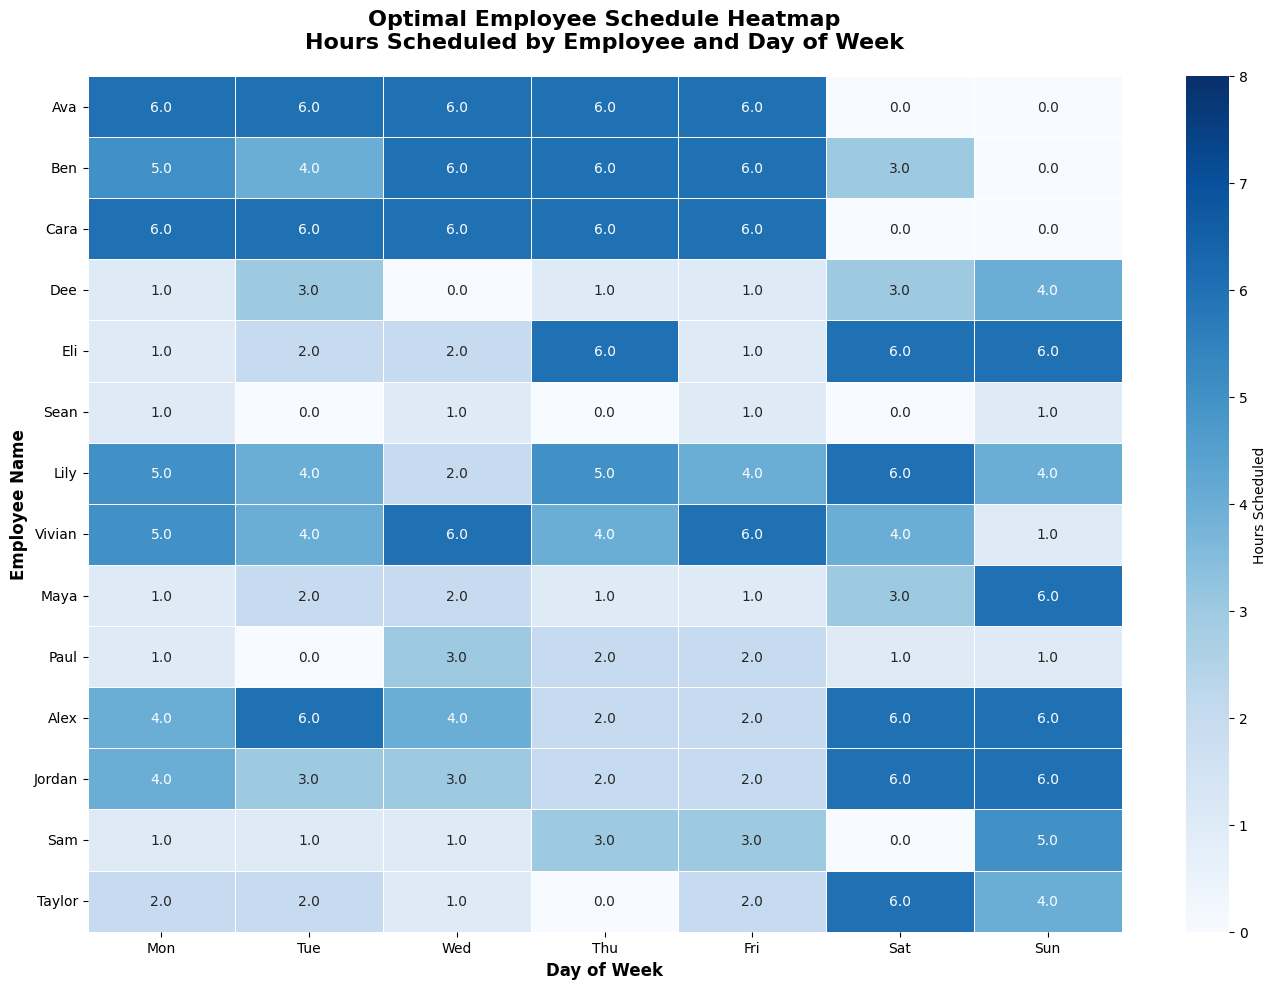

In [11]:
# Create schedule_by_day from schedule_df_output
# Employee data with drink making speeds
employee_data = {
    'Employee_ID': ['Ava', 'Ben', 'Cara', 'Dee', 'Eli', 'Sean', 'Lily', 'Vivian', 'Maya', 'Paul', 
                                        'Alex', 'Jordan', 'Sam', 'Taylor'],
    'Drinks_Per_Min': [1.2, 1.0, 1.4, 0.9, 1.1, 0.8, 1.2, 1.3, 1.1, 1.0,        
                        1.3, 1.2, 1.0, 1.1]
}

df_employees = pd.DataFrame(employee_data)

# Calculate tier-based hourly rates based on median
# Below median speed = $18/hour, Above median speed = $20/hour
speeds = df_employees['Drinks_Per_Min'].values
median_speed = np.median(speeds)

# Assign hourly rates based on median
hourly_rates = np.where(speeds < median_speed, 18, 20)

df_employees['Hourly_Rate'] = hourly_rates

# Identify employees in each tier
below_median_indices = np.where(speeds < median_speed)[0]
above_median_indices = np.where(speeds >= median_speed)[0]
# schedule_df_output has columns: Day, Hour, Chosen_employees, etc.
DAYS = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Initialize schedule matrix: employees (rows) x days (columns)
schedule_by_day = pd.DataFrame(index=df_employees['Employee_ID'], columns=DAYS)
schedule_by_day = schedule_by_day.fillna(0.0)  # Initialize with zeros

# Parse Chosen_employees column to count hours per employee per day
for idx, row in schedule_df_output.iterrows():
    day = row['Day']
    chosen_employees_str = row['Chosen_employees']
    
    # Skip if no employees assigned
    if pd.isna(chosen_employees_str) or chosen_employees_str == 'No Staff Found':
        continue
    
    # Parse comma-separated employee names
    employees_list = [emp.strip() for emp in str(chosen_employees_str).split(',')]
    
    # Each hour counts as 1 hour for each employee
    for emp in employees_list:
        if emp in schedule_by_day.index:
            schedule_by_day.loc[emp, day] += 1.0

schedule_by_day = schedule_by_day.astype(float)
# Create heatmap: Employees (rows) vs Days of Week (columns)
plt.figure(figsize=(14, 10))
sns.heatmap(
    schedule_by_day,
    annot=True,
    fmt='.1f',
    cmap='Blues',
    linewidths=0.5,
    cbar_kws={'label': 'Hours Scheduled'},
    vmin=0,
    vmax=8
)

plt.title('Optimal Employee Schedule Heatmap\nHours Scheduled by Employee and Day of Week', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Day of Week', fontsize=12, fontweight='bold')
plt.ylabel('Employee Name', fontsize=12, fontweight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('employee_schedule_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


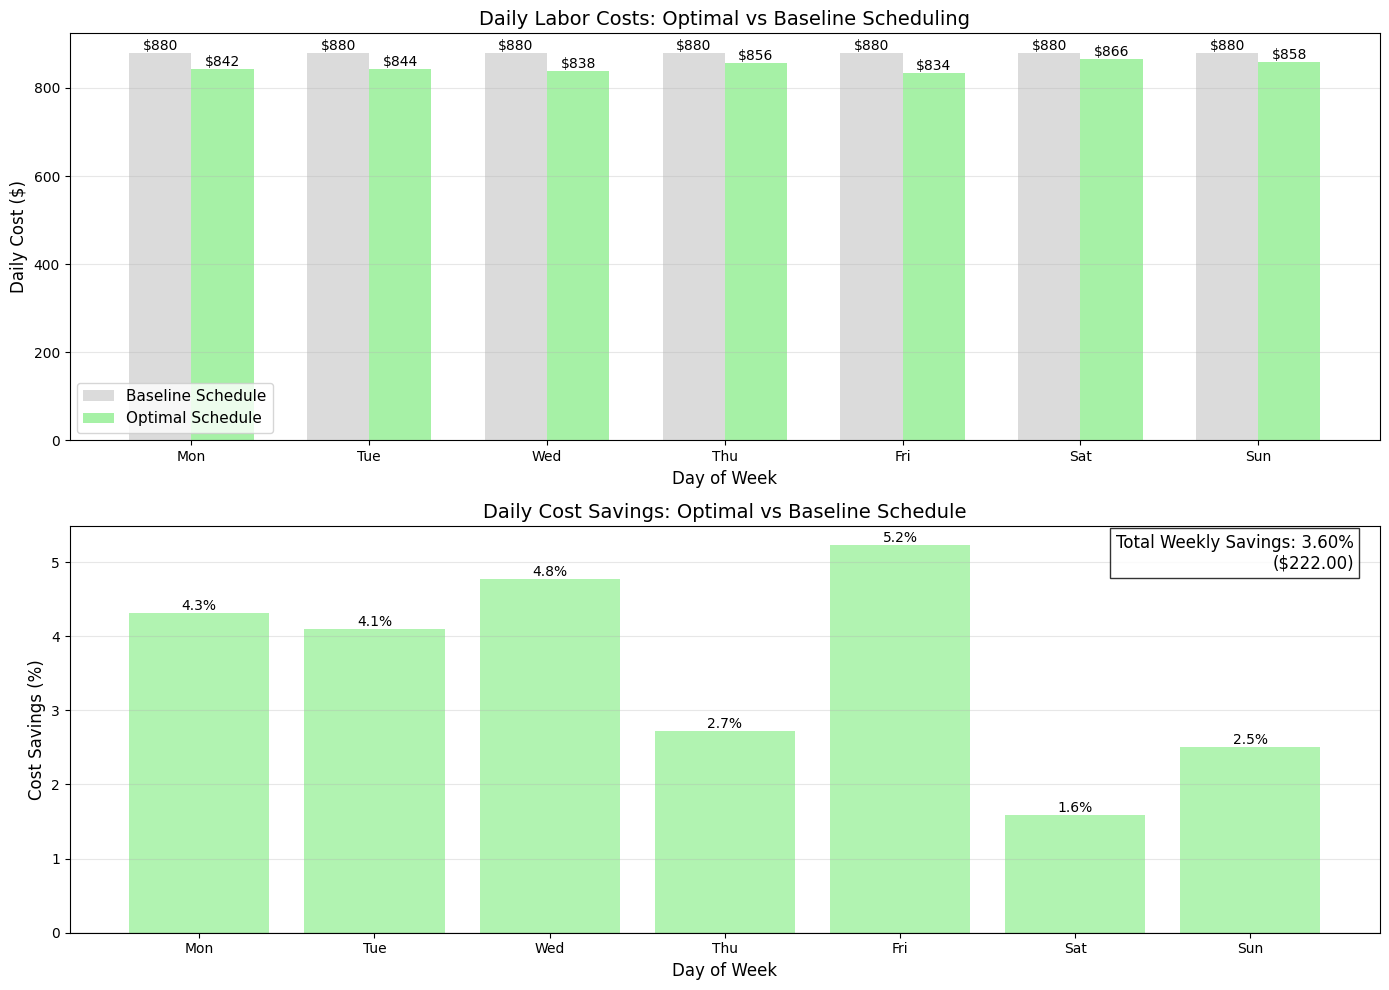

In [12]:
# Create cost savings visualization per day

# Calculate optimal_daily_costs from schedule_by_day
optimal_daily_costs = {}
for day in DAYS:
    day_cost = 0.0
    for emp in schedule_by_day.index:
        hours = schedule_by_day.loc[emp, day]
        hourly_rate = df_employees[df_employees['Employee_ID'] == emp]['Hourly_Rate'].values[0]
        day_cost += hours * hourly_rate
    optimal_daily_costs[day] = day_cost

# Calculate naive_daily_costs
HOURS_PER_DAY = 11
naive_cost_per_day = (20 + 20 + 20 + 20) * HOURS_PER_DAY  # 3 employees at $20/hr + 1 at $18/hr
naive_daily_costs = {day: naive_cost_per_day for day in DAYS}

# Calculate cost_savings
cost_savings = {day: naive_daily_costs[day] - optimal_daily_costs[day] for day in DAYS}

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Daily costs comparison
ax1 = axes[0]
x = np.arange(len(DAYS))
width = 0.35

naive_costs = [naive_daily_costs[d] for d in DAYS]
optimal_costs = [optimal_daily_costs[d] for d in DAYS]

bars1 = ax1.bar(x - width/2, naive_costs, width, label=f'Baseline Schedule', 
                color='lightgray', alpha=0.8)
bars2 = ax1.bar(x + width/2, optimal_costs, width, label='Optimal Schedule', 
                color='lightgreen', alpha=0.8)

ax1.set_xlabel('Day of Week', fontsize=12)
ax1.set_ylabel('Daily Cost ($)', fontsize=12)
ax1.set_title('Daily Labor Costs: Optimal vs Baseline Scheduling', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(DAYS)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.0f}',
                ha='center', va='bottom', fontsize=10)

# Plot 2: Cost savings per day (as percentage)
ax2 = axes[1]
savings_values = [cost_savings[d] for d in DAYS]
# Calculate savings as percentage of naive costs
savings_percentages = [100 * (cost_savings[d] / naive_daily_costs[d]) if naive_daily_costs[d] > 0 else 0 for d in DAYS]
colors = ['green' if s > 0 else 'red' for s in savings_percentages]

bars3 = ax2.bar(DAYS, savings_percentages, color="lightgreen",alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Day of Week', fontsize=12)
ax2.set_ylabel('Cost Savings (%)', fontsize=12)
ax2.set_title('Daily Cost Savings: Optimal vs Baseline Schedule', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, pct in zip(bars3, savings_percentages):
    height = bar.get_height()
    label = f'{pct:.1f}%'
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            label,
            ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# Add total savings annotation (as percentage)
total_naive_cost = sum(naive_daily_costs.values())
total_optimal_cost = sum(optimal_daily_costs.values())
total_savings_pct = 100 * (total_naive_cost - total_optimal_cost) / total_naive_cost if total_naive_cost > 0 else 0
total_savings_dollar = sum(savings_values)
ax2.text(0.98, 0.98, f'Total Weekly Savings: {total_savings_pct:.2f}%\n(${total_savings_dollar:.2f})',
         transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('cost_savings_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Summary statistics
HOURS_PER_DAY = 11
employees_20 = df_employees[df_employees['Hourly_Rate'] == 20]['Employee_ID'].tolist()[:3]
employees_18 = df_employees[df_employees['Hourly_Rate'] == 18]['Employee_ID'].tolist()[:1]
naive_employees = employees_20 + employees_18

naive_schedule = pd.DataFrame(index=df_employees['Employee_ID'], columns=DAYS)
naive_schedule = naive_schedule.fillna(0.0)
for emp in naive_employees:
    for day in DAYS:
        naive_schedule.loc[emp, day] = HOURS_PER_DAY  # 11 hours per day

# Calculate optimal_daily_costs from schedule_by_day (if not already calculated)
if 'optimal_daily_costs' not in globals():
    optimal_daily_costs = {}
    for day in DAYS:
        day_cost = 0.0
        for emp in schedule_by_day.index:
            hours = schedule_by_day.loc[emp, day]
            hourly_rate = df_employees[df_employees['Employee_ID'] == emp]['Hourly_Rate'].values[0]
            day_cost += hours * hourly_rate
        optimal_daily_costs[day] = day_cost

# Calculate naive_daily_costs (if not already calculated)
if 'naive_daily_costs' not in globals():
    naive_cost_per_day = (20 + 20 + 20 + 18) * HOURS_PER_DAY  # 3 employees at $20/hr + 1 at $18/hr
    naive_daily_costs = {day: naive_cost_per_day for day in DAYS}

# Calculate cost_savings (if not already calculated)
if 'cost_savings' not in globals():
    cost_savings = {day: naive_daily_costs[day] - optimal_daily_costs[day] for day in DAYS}

print("\n" + "="*60)
print("SCHEDULE AND COST SUMMARY")
print("="*60)

total_optimal_hours = schedule_by_day.sum().sum()
total_naive_hours = naive_schedule.sum().sum()

print(f"\nTotal Hours Scheduled:")
print(f"  Optimal Schedule: {total_optimal_hours:.1f} hours/week")
print(f"  Baseline Schedule: {total_naive_hours:.1f} hours/week")
print(f"  Difference: {total_naive_hours - total_optimal_hours:.1f} hours/week")

print(f"\nTotal Weekly Costs:")
print(f"  Optimal Schedule: ${sum(optimal_daily_costs.values()):.2f}")
print(f"  Baseline Schedule: ${sum(naive_daily_costs.values()):.2f}")
print(f"  Total Savings: ${sum(cost_savings.values()):.2f}")
print(f"  Savings Percentage: {100 * sum(cost_savings.values()) / sum(naive_daily_costs.values()):.2f}%")

print(f"\nAverage Daily Costs:")
print(f"  Optimal: ${np.mean(list(optimal_daily_costs.values())):.2f}")
print(f"  Baseline: ${np.mean(list(naive_daily_costs.values())):.2f}")
print(f"  Average Daily Savings: ${np.mean(list(cost_savings.values())):.2f}")



SCHEDULE AND COST SUMMARY

Total Hours Scheduled:
  Optimal Schedule: 304.0 hours/week
  Baseline Schedule: 308.0 hours/week
  Difference: 4.0 hours/week

Total Weekly Costs:
  Optimal Schedule: $5938.00
  Baseline Schedule: $6160.00
  Total Savings: $222.00
  Savings Percentage: 3.60%

Average Daily Costs:
  Optimal: $848.29
  Baseline: $880.00
  Average Daily Savings: $31.71


C:\Users\katie\AppData\Local\Temp\ipykernel_25720\1684056212.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  naive_schedule = naive_schedule.fillna(0.0)
